# Import dataset

In [1]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

## Load data from json file

In [2]:
df_issues = pd.read_json("dataset.json", lines=True)

In [3]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()


,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


In [4]:
# print all the columns
print(df_issues.columns)

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')


## Process label

In [5]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [6]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [7]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [8]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [9]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [10]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [11]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [12]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [13]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [14]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


## Plot the dataset

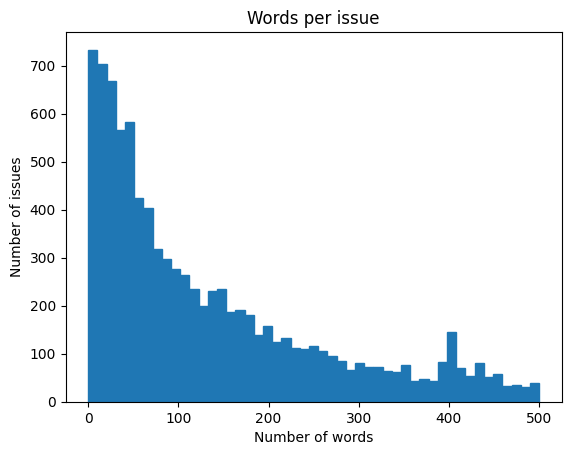

In [15]:
df_issues['text'].str.split().apply(len).hist(bins = np.linspace(0, 500, 50), grid=False, edgecolor='C0') 
plt.title("Words per issue") 
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Creating training set

In [16]:
#create balance split by using sk ml
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

## split dataset

In [17]:
from skmultilearn.model_selection import iterative_train_test_split 
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

In [18]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

## Create datasetDict

In [19]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

In [21]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


# Implementing a Naive Bayesline

In [22]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [23]:
# use f1 score and micro and macro to track performance
from collections import defaultdict

In [24]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [25]:
macro_scores , micro_scores = defaultdict(list), defaultdict(list)

In [26]:
# train the model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test_labels = np.array(ds["test"]["label_ids"])
    print(f"Train size: {len(ds_train_sample)}")

    # Use a simple count vectorizer to encode our texts as token counts
    count_vectorize = CountVectorizer()
    X_train_counts = count_vectorize.fit_transform(ds_train_sample["text"])
#     print("shape of X_train_counts: ", X_train_counts.shape)
#     print(f"shape of y_train {y_train.shape}")
    X_test_counts = count_vectorize.transform(ds["test"]["text"])
#     print(f"Vocabulary size: {len(count_vectorize.vocabulary_)}")   
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    print("Training done!")
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
            y_test_labels, y_pred_test, target_names=mlb.classes_, zero_division=0,
            output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

Train size: 10
Training done!
Train size: 19
Training done!
Train size: 36
Training done!
Train size: 68
Training done!
Train size: 134
Training done!
Train size: 223
Training done!


In [27]:
len(micro_scores['Naive Bayes'])

6

Naive Bayes


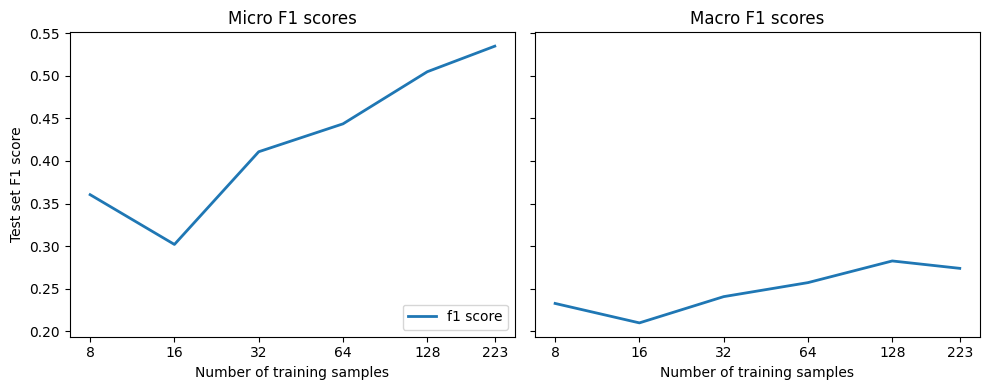

In [28]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = 'f1 score' , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = 'f1 score' , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# Working with no labled data

## Import the pipeline

In [29]:
from transformers import pipeline 
pipe = pipeline("fill-mask", model="bert-base-uncased")
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt, targets = ['animals', 'car']) 
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Token animals:	0.103%
Token car:	0.000%


In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


Token cars:	0.139%
Token animals:	0.006%


## Use Multi-Genre NLI Corpus (MNLI) to zero short the model

In [31]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
from transformers import pipeline 
pipe = pipeline("zero-shot-classification", device=device )
sample = ds["train"][0]
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")
for label, score in zip(output["labels"], output["scores"]):
     print(f"{label}, {score:.2f}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Add new CANINE model +  # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit toke

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.37
usage, 0.30
documentation, 0.26
pytorch, 0.25
model training, 0.24
tokenization, 0.20
pipeline, 0.17


In [33]:
def zero_shot_pipeline(example): 
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predictions"] = output["labels"]   
    example["scores"] = output["scores"] 
    return example 
ds_zero_shot = ds["valid"].map(zero_shot_pipeline) 


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [34]:
def get_preds(example, threshold = None , topk = None ): 
    '''Returns the predicted labels for a given example.'''
    preds = [] 
    if threshold: 
        for label, score in zip(example["predictions"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk: 
        for i in range(topk):
            preds.append(example["predictions"][i]) 
    else: 
        raise ValueError("Either threshold or topk must be set") 
    return {'pred_label_ids': list(np.squeeze(mlb.transform([preds])))}
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"]) 
    return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
            

## plot top-k pred

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

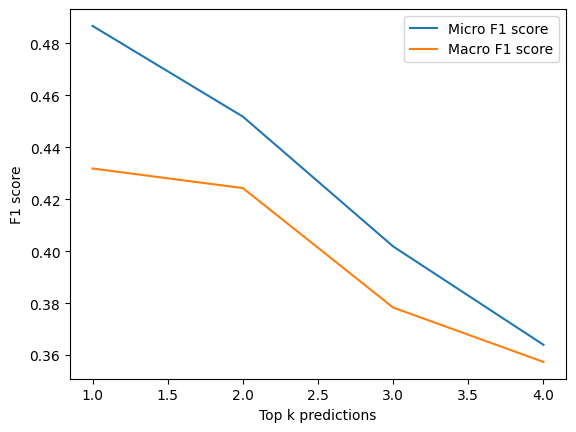

In [35]:
macros , micros = [] , []
topks = [1,2,3,4]
for topk in topks: 
    ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": topk}) 
    clf_report = get_clf_report(ds_zero_shot) 
    macros.append(clf_report["macro avg"]["f1-score"]) 
    micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(topks, micros, label="Micro F1 score")
plt.plot(topks, macros, label="Macro F1 score")
plt.xlabel("Top k predictions")
plt.ylabel("F1 score")
plt.legend(loc = 'best')
plt.show()

## plot threshold pred

In [ ]:
macros , micros = [] , []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds: 
    # dont print progress bar
    ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"threshold": threshold}) 
    clf_report = get_clf_report(ds_zero_shot) 
    macros.append(clf_report["macro avg"]["f1-score"]) 
    micros.append(clf_report["micro avg"]["f1-score"])

plt.plot(thresholds, micros, label="Micro F1 score")
plt.plot(thresholds, macros, label="Macro F1 score")
plt.xlabel("Threshold predictions")
plt.ylabel("F1 score")
plt.legend(loc = 'best')
plt.show()

In [37]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.78 with F1-score 0.48.
Best threshold (micro): 0.74 with F1-score 0.42.


In [38]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, batched = False, fn_kwargs={"topk": 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices: 
    macro_scores["Zero-Shot"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Zero-Shot"].append(clf_report["micro avg"]["f1-score"])


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Naive Bayes
Zero-Shot


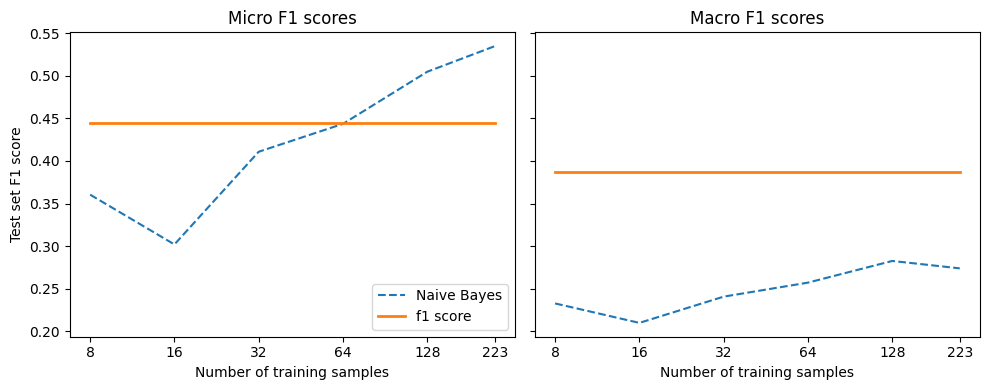

In [39]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero-Shot")